In [ ]:
# torch packages
import torch
import torchvision
!pip install torchinfo
import torchinfo
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.backends.cudnn as cudnn
!pip install torcheval
from torcheval.metrics.aggregation.auc import AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import torch.utils.data as data
from torch import optim
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets.utils import download_file_from_google_drive
print('PyTorch version:', torch.__version__)

# additional packages
!pip install mtcnn
from mtcnn import MTCNN
import cv2
from PIL import Image
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import random
import argparse
import os
import pickle
import time
from os.path import join
import csv
from sklearn import manifold
# install wget for data sharing
!pip install wget
import wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
PyTorch version: 1.13.1+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Face detection

In [ ]:
detector = MTCNN()

def load_and_crop(folder, real=True):
    idx = 0
    min_conf = 0.9
    for filename in os.listdir(folder):
      try:
          img = cv2.imread(os.path.join(folder,filename))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          result = detector.detect_faces(img)
          if result[0]['confidence'] > min_conf:
            bounding_box = result[0]['box']
            new_img = img[bounding_box[1]:bounding_box[1] + bounding_box[3], bounding_box[0]:bounding_box[0] + bounding_box[2]]
            if real == True:
              file_path = '/content/drive/MyDrive/cropped/real/'
              isExist = os.path.exists(file_path)
              if not isExist:
                 !mkdir /content/drive/MyDrive/cropped/
                 !mkdir /content/drive/MyDrive/cropped/real
              cv2.imwrite(file_path + str(idx) + '.png', cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))
              idx += 1
            else:
              file_path = '/content/drive/MyDrive/cropped/fake/'
              isExist = os.path.exists(file_path)
              if not isExist:
                 !mkdir /content/drive/MyDrive/cropped/
                 !mkdir /content/drive/MyDrive/cropped/fake
              cv2.imwrite(file_path + str(idx) + '.png', cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))
            idx += 1  
      except:  
        pass  

In [ ]:
file_path = '/content/drive/MyDrive/development_1/real'

load_and_crop(file_path, real = True)

1/1 [==============================] - 0s 53ms/step


In [ ]:
file_path = '/content/drive/MyDrive/development_1/fake'

load_and_crop(file_path, real = False)

1/1 [==============================] - 0s 51ms/step
mkdir: cannot create directory ‘/content/drive/MyDrive/cropped/’: File exists
1/1 [==============================] - 0s 36ms/step


In [ ]:
detector = MTCNN()

def load_and_crop_test(folder, real=True):
    idx = 0
    min_conf = 0.9
    for filename in os.listdir(folder):
      try:   
          img = cv2.imread(os.path.join(folder,filename))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          result = detector.detect_faces(img)       
          if result[0]['confidence'] > min_conf:
            bounding_box = result[0]['box']
            new_img = img[bounding_box[1]:bounding_box[1] + bounding_box[3], bounding_box[0]:bounding_box[0] + bounding_box[2]]
            if real == True:
              file_path = '/content/drive/MyDrive/cropped_test/real/'
              isExist = os.path.exists(file_path)
              if not isExist:
                 !mkdir /content/drive/MyDrive/cropped_test/
                 !mkdir /content/drive/MyDrive/cropped_test/real
              cv2.imwrite(file_path + str(idx) + '.png', cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))
              idx += 1
            else:
              file_path = '/content/drive/MyDrive/cropped_test/fake/'
              isExist = os.path.exists(file_path)
              if not isExist:
                 !mkdir /content/drive/MyDrive/cropped_test/
                 !mkdir /content/drive/MyDrive/cropped_test/fake
              cv2.imwrite(file_path + str(idx) + '.png', cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))
            idx += 1   
      except:
        pass     

In [ ]:
file_path = '/content/drive/MyDrive/evaluation_1/real'

load_and_crop_test(file_path, real = True)

1/1 [==============================] - 0s 42ms/step


In [ ]:
file_path = '/content/drive/MyDrive/evaluation_1/fake'

load_and_crop_test(file_path, real = False)

1/1 [==============================] - 0s 46ms/step
mkdir: cannot create directory ‘/content/drive/MyDrive/cropped_test/’: File exists
1/1 [==============================] - 0s 35ms/step


In [ ]:
image_size = 200
batch_size = 16

train_transform = transforms.Compose([
#    transforms.CenterCrop((200,200)),
    transforms.Resize((image_size,image_size), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))
#    transforms.RandomErasing(),
])

test_transform = transforms.Compose([
#    transforms.CenterCrop((200,200)),
    transforms.Resize((image_size,image_size), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))
])

In [ ]:
train_path = '/content/drive/MyDrive/cropped'
test_path = '/content/drive/MyDrive/cropped_test'
train_dataset = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
train_data, val_data = random_split(train_dataset, [683, 75])

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=test_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

classes = ('fake', 'real')

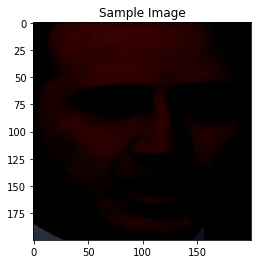

tensor(0)


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
#    inp = inp / 2 + 0.5     # unnormalize
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    title = 'Sample Image'
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0])
imshow(out)
print(classes[0]) # 1 is real, 0 is fake

# Task 1

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1 = nn.Linear(16 * 48 * 48, 16) # (64 * 6 * 6)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.drop(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.sigmoid(self.fc2(x))
        return x


model = Net()

In [ ]:
torchinfo.summary(Net(), [(3, 200, 200)], batch_dim = 0, verbose = 0)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 1]                    --
├─Conv2d: 1-1                            [1, 8, 198, 198]          224
├─MaxPool2d: 1-2                         [1, 8, 99, 99]            --
├─Conv2d: 1-3                            [1, 16, 97, 97]           1,168
├─MaxPool2d: 1-4                         [1, 16, 48, 48]           --
├─Dropout: 1-5                           [1, 16, 48, 48]           --
├─Linear: 1-6                            [1, 16]                   589,840
├─Dropout: 1-7                           [1, 16]                   --
├─Linear: 1-8                            [1, 1]                    17
├─Sigmoid: 1-9                           [1, 1]                    --
Total params: 591,249
Trainable params: 591,249
Non-trainable params: 0
Total mult-adds (M): 20.36
Input size (MB): 0.48
Forward/backward pass size (MB): 3.71
Params size (MB): 2.36
Estimated Total Size (MB): 6.56

In [ ]:
loss_fn = nn.BCELoss()
LR = 0.001
optim = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=0.0001)
epoch_loss_DA = []
val_loss_DA = []
acc_DA = []
train_time = 0

epochs = 15

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

model.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
for i in range(epochs):
    start_time = time.time()
    ep = 0
    model.train()
    for X_b, y_b in train_loader:
        optim.zero_grad()
        X_b = X_b.to(device)
        y_b = y_b.to(device)
        output = model(X_b)
        loss = loss_fn(output.squeeze(1).to(torch.float32), y_b.to(torch.float32))
        loss.backward()
        ep += loss.item()
        optim.step()
    epoch_loss_DA.append(ep*batch_size/683)
    train_time += time.time() - start_time
    
    correct = 0
    total = 0
    val = 0
    model.eval()
    
    for X_b, y_b in val_loader:
        X_b = X_b.to(device)
        y_b = y_b.to(device)
        output = model(X_b)
        val_loss = loss_fn(output.squeeze(1).to(torch.float32), y_b.to(torch.float32))
        val += val_loss.item()
        correct += float(torch.sum(output.round().int() == y_b))
        total += y_b.shape[0]
    val_loss_DA.append(val*batch_size/75)
    acc_DA.append(round(correct/total,2))
    
    print(f'[{i:03d}] train loss: {ep*batch_size/683:04f}  '
              f'val loss: {val*batch_size/75:04f}  '
              f'val acc: {correct/len(train_dataset)*100:04f}%')
    
print("--- %s seconds ---", train_time)    

[000] train loss: 0.716945  val loss: 0.629824  val acc: 78.496042%
[001] train loss: 0.581255  val loss: 0.498971  val acc: 79.947230%
[002] train loss: 0.445761  val loss: 0.446326  val acc: 82.585752%
[003] train loss: 0.380436  val loss: 0.324060  val acc: 79.023747%
[004] train loss: 0.302758  val loss: 0.305329  val acc: 78.627968%
[005] train loss: 0.251877  val loss: 0.251351  val acc: 76.121372%
[006] train loss: 0.182560  val loss: 0.207807  val acc: 81.530343%
[007] train loss: 0.147827  val loss: 0.234639  val acc: 76.912929%
[008] train loss: 0.135666  val loss: 0.236770  val acc: 77.836412%
[009] train loss: 0.124642  val loss: 0.146821  val acc: 78.100264%
[010] train loss: 0.093731  val loss: 0.150688  val acc: 77.572559%
[011] train loss: 0.096511  val loss: 0.222117  val acc: 79.947230%
[012] train loss: 0.105361  val loss: 0.279173  val acc: 81.662269%
[013] train loss: 0.148042  val loss: 0.199097  val acc: 79.815303%
[014] train loss: 0.105135  val loss: 0.070824  

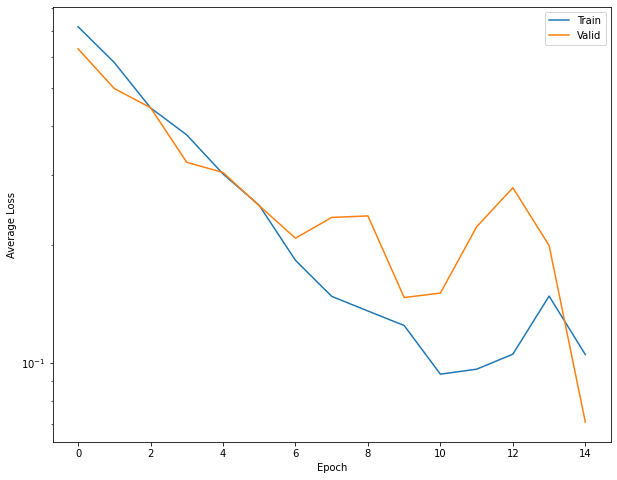

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(epoch_loss_DA, label='Train')
plt.semilogy(val_loss_DA, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
correct = 0
total = 0
auc = 0
all_outputs = []
all_labels = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    model.eval()
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images).squeeze(1)
        total += labels.size(0)
        correct += (outputs.round().int() == labels).sum().item()  
        all_outputs.extend(outputs.cpu())
        all_labels.extend(labels.cpu())

auc = roc_auc_score(all_labels, all_outputs)
#print AUC score
print(f'AUC of the network on the test images: {auc} ')

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

AUC of the network on the test images: 0.9664545454545455 
Accuracy of the network on the test images: 90 %


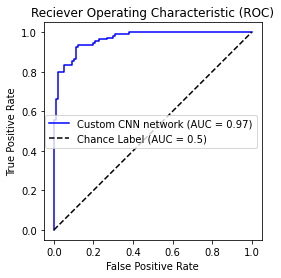

In [ ]:
RocCurveDisplay.from_predictions(
    all_labels,
    all_outputs,
    name="Custom CNN network",
    color="blue"
)
plt.plot([0, 1], [0, 1], "k--", label="Chance Label (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Reciever Operating Characteristic (ROC)")
plt.legend()
plt.show()

# Task 2

In [ ]:
detector = MTCNN()

def load_and_crop_test(folder, real=True):
    idx = 0
    min_conf = 0.9
    for filename in os.listdir(folder):
      try:   
          img = cv2.imread(os.path.join(folder,filename))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          result = detector.detect_faces(img)       
          if result[0]['confidence'] > min_conf:
            bounding_box = result[0]['box']
            new_img = img[bounding_box[1]:bounding_box[1] + bounding_box[3], bounding_box[0]:bounding_box[0] + bounding_box[2]]
            if real == True:
              file_path = '/content/drive/MyDrive/cropped_test_2/real/'
              isExist = os.path.exists(file_path)
              if not isExist:
                 !mkdir /content/drive/MyDrive/cropped_test_2/
                 !mkdir /content/drive/MyDrive/cropped_test_2/real
              cv2.imwrite(file_path + str(idx) + '.png', cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))
              idx += 1
            else:
              file_path = '/content/drive/MyDrive/cropped_test_2/fake/'
              isExist = os.path.exists(file_path)
              if not isExist:
                 !mkdir /content/drive/MyDrive/cropped_test_2/
                 !mkdir /content/drive/MyDrive/cropped_test_2/fake
              cv2.imwrite(file_path + str(idx) + '.png', cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))
            idx += 1   
      except:
        pass   

In [ ]:
file_path = '/content/drive/MyDrive/evaluation_2/real'

load_and_crop_test(file_path, real = True)

1/1 [==============================] - 0s 46ms/step


In [ ]:
file_path = '/content/drive/MyDrive/evaluation_2/fake'

load_and_crop_test(file_path, real = False)

1/1 [==============================] - 0s 24ms/step
mkdir: cannot create directory ‘/content/drive/MyDrive/cropped_test_2/’: File exists
1/1 [==============================] - 0s 22ms/step


In [ ]:
test_transform_2 = transforms.Compose([
#    transforms.CenterCrop((200,200)),
    transforms.Resize((image_size,image_size), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))
])

In [ ]:
test_path_2 = '/content/drive/MyDrive/cropped_test_2'

test_dataset_2 = torchvision.datasets.ImageFolder(test_path_2, transform=test_transform_2)
test_loader_2 = DataLoader(dataset=test_dataset_2, batch_size=batch_size, shuffle=True)

classes = ('fake', 'real')

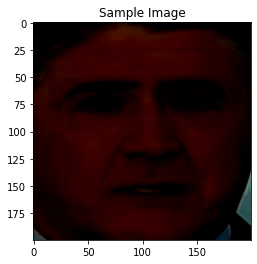

tensor(0)


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
#    inp = inp / 2 + 0.5     # unnormalize
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    title = 'Sample Image'
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0])
imshow(out)
print(classes[0]) # 1 is real, 0 is fake

In [ ]:
correct = 0
total = 0
auc = 0
all_outputs = []
all_labels = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    model.eval()
    for data in test_loader_2:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images).squeeze(1)
        total += labels.size(0)
        correct += (outputs.round().int() == labels).sum().item()  
        all_outputs.extend(outputs.cpu())
        all_labels.extend(labels.cpu())

auc = roc_auc_score(all_labels, all_outputs)
#print AUC score
print(f'AUC of the network on the test images: {auc} ')

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

AUC of the network on the test images: 0.6557999999999999 
Accuracy of the network on the test images: 59 %


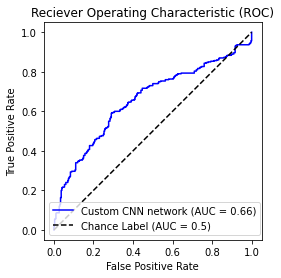

In [ ]:
RocCurveDisplay.from_predictions(
    all_labels,
    all_outputs,
    name="Custom CNN network",
    color="blue"
)
plt.plot([0, 1], [0, 1], "k--", label="Chance Label (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Reciever Operating Characteristic (ROC)")
plt.legend()
plt.show()